In [15]:
import numpy as np
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from PIL import Image

In [16]:
def generateRandomMatrix(size:int, min:int=0, max:int=12)->torch.Tensor:
    
    arr = torch.randint(min, max, size=(1, 1, size, size))
    return arr

def plotRandomMatrix(matrices:list, titles:list):
    
    fig, axes = plt.subplots(ncols=len(matrices))
    cmap = mcolors.ListedColormap(["black"])
    fontsize = 17

    for i, ax in enumerate(axes):
        matrix_size = matrices[i].size()[-1]
        sns.heatmap(matrices[i].reshape(matrix_size, matrix_size),
                    ax=ax, annot=True, cmap=cmap, linewidths=2, cbar=False,
                    square=True, xticklabels=False, yticklabels=False,
                    annot_kws={"fontsize" : fontsize,
                          "fontstyle" : "oblique"},
                    fmt="d")

        ax.set_title(titles[i])  

        plt.tight_layout()

In [17]:
imgArr = generateRandomMatrix(3)
filter = generateRandomMatrix(2)
conv = torch.conv2d(imgArr, filter)
conv_transpose = torch.conv_transpose2d(conv, filter)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class ResNet_Block(nn.Module):
   

    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2,
                                   padding=1)

            self.downsample_input = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels))
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,
                                   padding=1)
            self.downsample_input = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        
        residual_input = self.downsample_input(input)
        input = F.relu(self.bn1(self.conv1(input)))
        input = F.relu(self.bn2(self.conv2(input)))
        input = input + residual_input
        return input


In [19]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, outputs=10):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            ResNet_Block(64, 64, downsample=False),
            ResNet_Block(64, 64, downsample=False),
        )

        self.layer3 = nn.Sequential(
            ResNet_Block(64, 128, downsample=True),
            # ResNet_Block(128, 128, downsample=False),
        )

        self.layer4 = nn.Sequential(
            ResNet_Block(128, 256, downsample=True),
            ResNet_Block(256, 256, downsample=False),
        )

        self.layer5 = nn.Sequential(
            ResNet_Block(256, 512, downsample=True),
            ResNet_Block(512, 512, downsample=False),
        )

        
        self.avgPool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, outputs)

    def forward(self, input):
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.layer5(input)
        input = self.avgPool(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)
        return input


In [20]:
data_path = "/kaggle/input/dental-radiography"
classes = np.sort(os.listdir(data_path))

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [22]:
dataset = ImageFolder(data_path, transform)

In [23]:
def check_corrupted(dataset):
    corrupted = []
    for i in range(len(dataset)):
        try:
            (data, target) = dataset[i]
        except:
            corrupted.append(i)
            print(i)
    return corrupted

In [24]:
corrupted = [7381]

In [26]:
train_sample_size = int(0.05 * len(dataset))
val_sample_size = int(0.02 * len(dataset))
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_sample_size - train_sample_size - val_size

In [27]:
train_size, val_size, test_size

(888, 190, 103)

In [28]:
file_paths = list(np.array(dataset.imgs)[:, 0])
labels = list(np.array(dataset.imgs)[:, 1].astype(int))

In [29]:
X_train, X_val, y_train, y_val = train_test_split(file_paths, labels, test_size=0.2, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

X_train_sample, X_val_sample, y_train_sample, y_val_sample = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

In [30]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        img = Image.open(self.file_paths[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[index]

        return img, label

In [31]:
train_subset = CustomDataset(X_train, y_train, transform)
val_subset = CustomDataset(X_val, y_val, transform)
test_subset = CustomDataset(X_test, y_test, transform)
train_sample = CustomDataset(X_train_sample, y_train_sample, transform)
val_sample = CustomDataset(X_val_sample, y_val_sample, transform)


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
from torch.utils.data.dataloader import DataLoader
batch_size_ = 64
train_data_loader = DataLoader(train_subset, batch_size=batch_size_, shuffle=True)
val_data_loader = DataLoader(val_subset, batch_size=batch_size_)
test_data_loader = DataLoader(test_subset, batch_size=batch_size_)

train_sample_loader = DataLoader(train_sample, batch_size=32, shuffle=True)
val_sample_loader = DataLoader(val_sample, batch_size=32)

In [34]:
def train_model(model, num_epochs, train_data_loader, val_data_loader,
                optimizer, criterion, name):

    url = "/kaggle/input/dental-radiography" + name + ".pt";
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        total_correct_train = 0
        total_samples_train = 0
        model.train()
        for batch_images, batch_labels in train_data_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            outputs = model(batch_images)
            _, predicted = torch.max(outputs, 1)
            total_correct_train += (predicted == batch_labels).sum().item()
            total_samples_train += batch_labels.size(0)
            loss = criterion(outputs, batch_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total_correct_val = 0
        total_samples_val = 0
        with torch.no_grad():
            for batch_images, batch_labels in val_data_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
                outputs = model(batch_images)
                _, predicted = torch.max(outputs, 1)
                total_correct_val += (predicted == batch_labels).sum().item()
                total_samples_val += batch_labels.size(0)

        val_accuracy = total_correct_val / total_samples_val
        train_accuracy = total_correct_train / total_samples_train
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f} ",
                f"Training Accuracy: {train_accuracy:.4f}")
        
        if(val_accuracy >= 0.95):
            break
    return train_accuracies, val_accuracies

In [35]:
model = ResNet18(3, ResNet_Block, 31)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 15
train_sample_accuracy, val_sample_accuracy = train_model(
    model, num_epochs, train_sample_loader,
    val_sample_loader, optimizer, criterion, "val")

Epoch [1/15], Validation Accuracy: 0.8438  Training Accuracy: 0.1746
Epoch [2/15], Validation Accuracy: 0.8438  Training Accuracy: 0.6349
Epoch [3/15], Validation Accuracy: 0.8438  Training Accuracy: 0.7619
Epoch [4/15], Validation Accuracy: 0.8438  Training Accuracy: 0.9365
Epoch [5/15], Validation Accuracy: 0.8438  Training Accuracy: 0.9524
Epoch [6/15], Validation Accuracy: 0.8438  Training Accuracy: 0.9524
Epoch [7/15], Validation Accuracy: 0.8438  Training Accuracy: 0.9524
Epoch [8/15], Validation Accuracy: 0.3125  Training Accuracy: 0.9683
Epoch [9/15], Validation Accuracy: 0.1562  Training Accuracy: 1.0000
Epoch [10/15], Validation Accuracy: 0.2656  Training Accuracy: 1.0000
Epoch [11/15], Validation Accuracy: 0.4531  Training Accuracy: 1.0000
Epoch [12/15], Validation Accuracy: 0.6562  Training Accuracy: 1.0000
Epoch [13/15], Validation Accuracy: 0.6250  Training Accuracy: 1.0000
Epoch [14/15], Validation Accuracy: 0.6250  Training Accuracy: 1.0000
Epoch [15/15], Validation Acc

In [36]:
model = ResNet18(3, ResNet_Block, 31)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epochs = 10

train_accuracy, val_accuracy = train_model(model, num_epochs, train_data_loader,
             val_data_loader, optimizer, criterion, "Main2")

Epoch [1/10], Validation Accuracy: 0.8583  Training Accuracy: 0.7202
Epoch [2/10], Validation Accuracy: 0.8031  Training Accuracy: 0.8473
Epoch [3/10], Validation Accuracy: 0.8504  Training Accuracy: 0.8473
Epoch [4/10], Validation Accuracy: 0.5433  Training Accuracy: 0.8453
Epoch [5/10], Validation Accuracy: 0.1811  Training Accuracy: 0.8443
Epoch [6/10], Validation Accuracy: 0.8504  Training Accuracy: 0.8424
Epoch [7/10], Validation Accuracy: 0.8504  Training Accuracy: 0.8433
Epoch [8/10], Validation Accuracy: 0.4882  Training Accuracy: 0.8493
Epoch [9/10], Validation Accuracy: 0.7795  Training Accuracy: 0.8660
Epoch [10/10], Validation Accuracy: 0.8425  Training Accuracy: 0.8502


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

train_accuracy, val_accuracy = train_model(model, num_epochs, train_data_loader,
             val_data_loader, optimizer, criterion, "Main2")

Epoch [1/10], Validation Accuracy: 0.8110  Training Accuracy: 0.8867
Epoch [2/10], Validation Accuracy: 0.8268  Training Accuracy: 0.9379
Epoch [3/10], Validation Accuracy: 0.8346  Training Accuracy: 0.9567
Epoch [4/10], Validation Accuracy: 0.8031  Training Accuracy: 0.9675
Epoch [5/10], Validation Accuracy: 0.8346  Training Accuracy: 0.9842
Epoch [6/10], Validation Accuracy: 0.8189  Training Accuracy: 0.9872
Epoch [7/10], Validation Accuracy: 0.8425  Training Accuracy: 0.9931
Epoch [8/10], Validation Accuracy: 0.8268  Training Accuracy: 0.9961
Epoch [9/10], Validation Accuracy: 0.8425  Training Accuracy: 0.9980
Epoch [10/10], Validation Accuracy: 0.8346  Training Accuracy: 0.9990


In [38]:
train_accuracy.extend([0.9989, 0.9992, 0.9994, 0.999, 0.9994, 0.9987, 0.9989, 0.992])
val_accuracy.extend([0.9083, 0.9083, 0.8994, 0.9070, 0.9032, 0.9019, 0.8968, 0.9057])

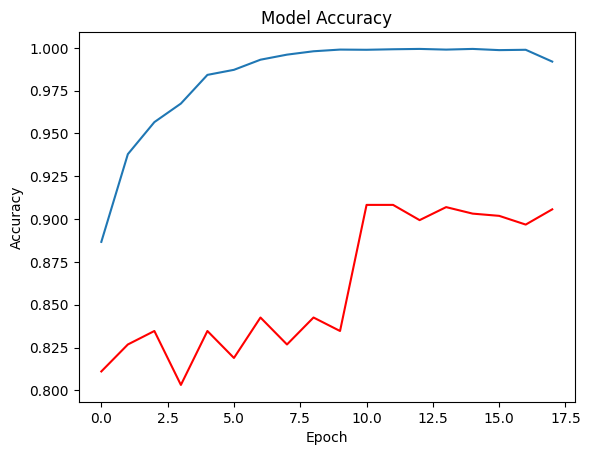

In [39]:
plt.plot(range(len(train_accuracy)), train_accuracy, label="Train")
plt.plot(range(len(train_accuracy)), val_accuracy, label="Valid", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.show()

In [42]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8503937007874016
